<img src="./img/vs265header.svg"/>


<h1 align="center">Lab 3 - Unsupervised Learning </h1> 
<h2 align="center"> Part 2 - Faces </h2>

In [1]:
%pylab inline
  
import matplotlib.animation as animation
import base64

import utils.anim as anim
import utils.lab3utils as util

faces = np.load('./data/yalefaces.npz')['faces'].T

Populating the interactive namespace from numpy and matplotlib


In [2]:
# WINDOWS USERS ONLY:
# the animations in this notebook generate small video files stored in the ./utils/ directory
# running this cell will clear those files for you.

# please run this cell right before turning in your problem set

anim.clearFiles()

## Eigenfaces

The file `data/yalefaces.npz` is used in this problem. It contains a 3965x120 array. Each column contains an image of a face. You must reshape the 3965x1 column vector into a 61x65 matrix to make it an image. For example, to view the first 32 faces, run the code in the cell below.

**Handy JuPyter Tip**: You can single-click the area to the left of the output to switch between a fixed-size output and a scrolling output. You can also double-click the same area to collapse the output entirely. This is useful for situations like this one where you have an output that takes up a lot of screen real estate.

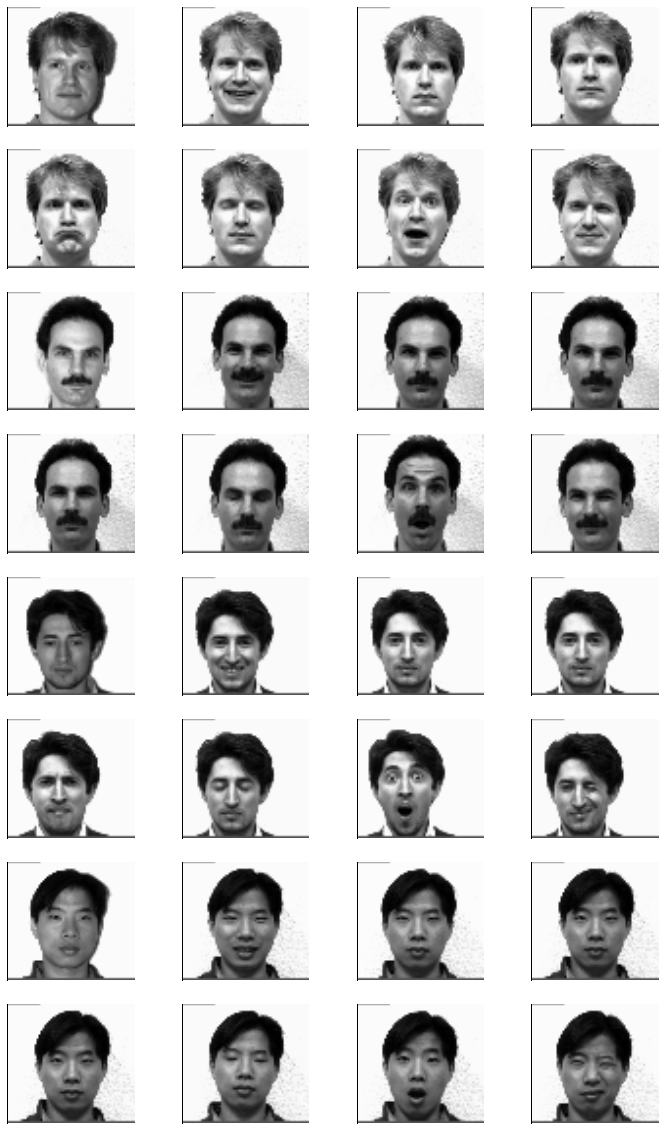

In [3]:
plt.figure(figsize=(12,20))

N = 32 #faces.shape[1] #<- uncomment to see the whole dataset at once

numCols = 4
numRows = N//numCols+((N%numCols)>0); #compute the grid shape from N

for i in range(N):
    faceColumn = faces[:,i]
    faceImage = util.faceReshape(faceColumn)
    
    plt.subplot(numRows,numCols,i+1)
    
    util.facePlot(faceImage)

### The Average Face

Compute the average face and take a look at it by plotting it with `util.facePlot`. Thefunction `util.faceInitialize` below will subtract this face from the data before running `sangerLearn`. Why do we need to do this? (Hint: check out p201 of Hertz, Krogh, and Palmer).

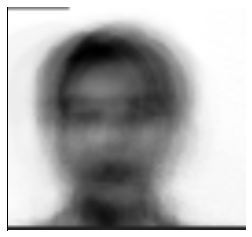

In [4]:
averageFace = np.mean(faces, axis=1) # YOUR CODE HERE
util.facePlot(util.faceReshape(averageFace));

##### YOUR ANSWER HERE

Subtracting the mean from the data centers the distribution of each dimension around 0. We want to do this because we want our first principal component to tells us as much information as possible about our face *relative to the other faces* in the dataset. Each pixel is correlated with the same pixel in other samples; we don't want the first principal component to capture that information because it doesn't tell us interesting about the face.

### Sanger's Rule for Faces

Use Sanger's Rule to learn the first four (or more if you like) principal components of the data (the so-called "eigenfaces"). Show what these look like. You should be able to use the exact same `sangerLearn` code from the first half of the problem set.

In [5]:
# copy your sangerLearn function from lab3_1
def sangerLearn(dataset,weights,learningRate):
    """
    Weight update with the Sanger rule.
    weights and learningRate should be provided by output of util.initialize()
    
    Parameters
    ----------
    dataset      : dataset, numpy array, either D1 or D2
    weights      : numpy array, weight matrix of linear transformation of input data
    learningRate : float, factor to multiply weight updates
    
    Returns
    -------
    weights      : numpy array, Sanger-updated weight matrix 
                                 of linear transformation of input data
                                 
    NOTE: if you add any additional parameters to this function, you need to
    also add them to the "argumentsForOjaLearn" list variable
    """
    
    output = weights.T @ dataset # YOUR CODE - compute neuron output for all data
    numOutputs = output.shape[0]
    
    residual = dataset # YOUR CODE - what does the "residual" term start out as?
    # HINT: Sanger's rule for one neuron reduces to Oja's rule
    
    dw = np.zeros(weights.shape)
    
    for i in range(numOutputs):
        residual = residual - weights[:, i, None] @ output[None, i]
        dw[:, i] = np.sum(output[i] * residual, axis=1)
        
    weights += dw*learningRate # update weight vector by dw
    
    return weights

In [29]:
numOutputs = 8 #how many PCs should we find?

learningRate = 1*10**-8 #decrease this value if you get a Warning: converting a masked element to nan.

faces, weights, learningRate = util.faceInitialize(faces,numOutputs=numOutputs,learningRate=learningRate)

In [30]:
numSteps = 2500 #needs to be made bigger when numOutputs (i.e. number of PCs to learn) is made bigger

for i in range(numSteps):
    weights = sangerLearn(faces,weights,learningRate) # this takes awhile!

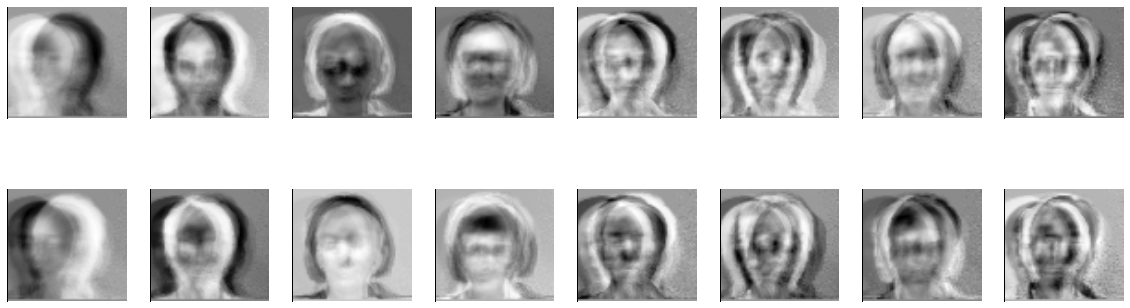

In [31]:
plt.figure(figsize=(20,6))

for i in range(numOutputs):
    plt.subplot(2,numOutputs,i+1)
    util.facePlot(util.faceReshape(weights[:,i]))
    plt.subplot(2,numOutputs,i+1+numOutputs)
    util.facePlot(-1*util.faceReshape(weights[:,i]))

You can view the axis of variation captured by each of the learned principal components using the code below. Simply change the index in the indicated line to change the eigenface that is animated.

In [21]:
numFrames = 300

#change the index in the following line:
vector,target = util.pickEigenvector(0,weights) #starting at 0

normalizingConstant = np.sqrt(np.sum(np.square(averageFace)))

figure = plt.figure(); 
imageHandle = util.facePlot(util.faceReshape(normalizingConstant*vector+averageFace))

eigAnim = animation.FuncAnimation(figure, util.eigenFrame, init_func=anim.init,interval=2,
                                    fargs=[imageHandle,vector,target,numFrames,averageFace,normalizingConstant], 
                                    frames=numFrames, 
                                    )

anim.display_animation(eigAnim,fps=75)

### Dimensionality Reduction

Plot each face as a point in the two-dimensional space spanned by the first two PCs.
We obtain the coordinates of those points by projecting the face onto those two PCs.

What would this projection look like for Gaussian data? Does the projection for this data look like that? What does this tell you about the data?

##### YOUR ANSWER HERE

For gaussian data, the projection itself should look like a 2d gaussian, since all the points should be mapped onto this plane. However, the face data does not form a gaussian but rather a parabolic shape where high and low PC1 values correspond to similar PC2 values, but intermediate PC1 values correspond to different PC2 values. This suggests that the top two principal components are not independent, and that the underlying distribution is not really gaussian.  

In [32]:
colorList = ['red','orange','yellow','blue','black','brown','gray',
             'skyblue','tomato','mediumspringgreen',
            'plum','darkcyan','indigo','darkolivegreen','hotpink']

numPoses = 8
numFaces = faces.shape[1]
numIndividuals = numFaces//numPoses #floor division

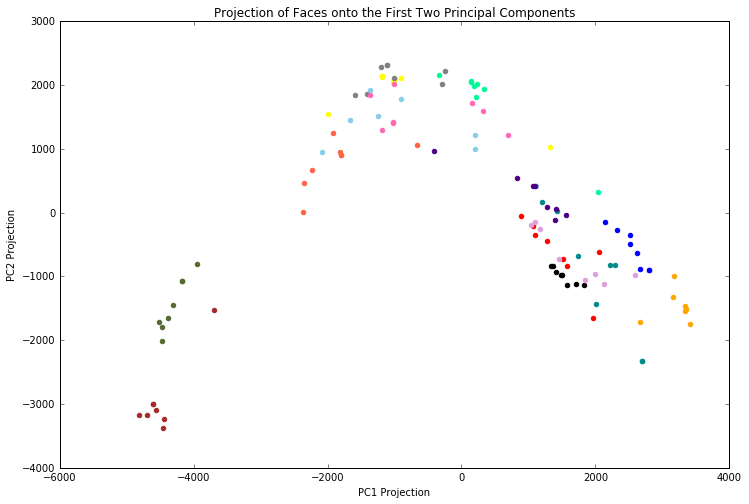

In [33]:
plt.figure(figsize=(12,8))

projectionVectors = weights[:, :2] # YOUR CODE HERE

for i in range(numIndividuals):
    startIndex = i*numPoses; endIndex = startIndex+numPoses
    faceColumns = faces[:,startIndex:endIndex]
    projection = projectionVectors.T @ faceColumns # YOUR CODE HERE 
    plt.scatter(projection[0,:],projection[1,:],color=colorList[i])

plt.title('Projection of Faces onto the First Two Principal Components')
plt.xlabel('PC1 Projection'); plt.ylabel('PC2 Projection');

### Reconstruction

Pick a face and show what the reconstructions look like as you reconstruct with progressively more principal components. Remember to add back in the mean face before you reconstruct. If the first face you pick doesn't work, try several different faces. If your reconstructions are bad, you might also want to go back and learn more PCs (say, 8).

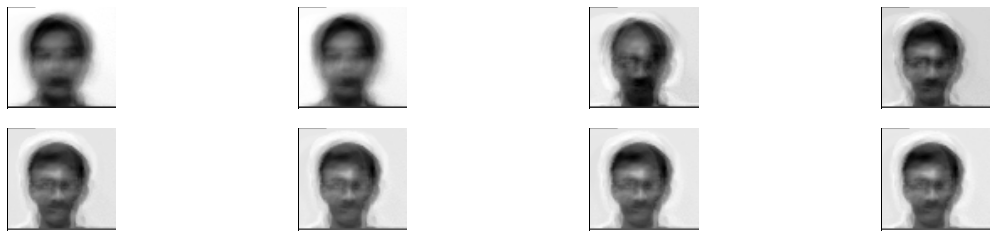

In [34]:
faceIndex = 102

faceColumn = faces[:,faceIndex,None] #keeps column shape

maxComponents = weights.shape[1]

plt.figure(figsize=(20,4))

for i in range(maxComponents):
    projectionVectors = weights[:, :i+1]# YOUR CODE HERE - same vectors as before, but different set in each iteration
    projection = projectionVectors.T @ faceColumn # YOUR CODE HERE - exactly the same as above
    
    #now, return to the coordinates in the full face-space by "up-projecting"
    reconstruction = projectionVectors @ projection + averageFace[:, None] #YOUR CODE HERE - something+averageFace[:,None] 
    if maxComponents > 4:
        plt.subplot(2,maxComponents//2,i+1)
    else:
        plt.subplot(1,maxComponents,i+1)
    util.facePlot(util.faceReshape(reconstruction))

### Winner-Take-All Learning

Now train a WTA network on the faces data. You should experiment
with different numbers of units. Do the learned weight vectors appear any more
meaningful than those learned by PCA?

A side note for those familiar with the K-means algorithm: the WTA network learning
rule basically performs stochastic gradient descent on the same objective
function as K-means. See the discussion on page 222 of Hertz, Krogh, and Palmer.

##### YOUR ANSWER HERE

The WTA network definitely seems to be extracting more meaningful weight vectors, as it seems to be finding groups of input representing the same face or similar looking faces. However, there are also weight vectors that seems to have kind of strange representations, like occasionally you find ones that are just noise. This probably corresponds to the badly initialized weight vector that can't win against any other vectors throughout learning.

In [35]:
def WTALearn(dataset,weights,learningRate):
    """
    Weight update with the WTA rule.
    weights and learningRate should be provided by output of initializeWTA()
    
    Parameters
    ----------
    dataset      : dataset, numpy array, either D1 or D2
    weights      : numpy array, weight matrix of linear transformation of input data
    learningRate : float, factor to multiply weight updates
    
    Returns
    -------
    weights      : numpy array, Sanger-updated weight matrix 
                                 of linear transformation of input data
    """
    
    output = weights.T @ dataset # YOUR CODE - compute neuron output for all data
    winnerIndices = np.argmax(output, axis=0)  # YOUR CODE - look up np.argmax
    
    numOutputs = output.shape[0]
    
    dw = np.zeros(weights.shape)
    
    for i in range(numOutputs):
        dw[:,i] = learningRate * (dataset - weights[:, winnerIndices]) @ (i == winnerIndices)
    
    weights += dw
    
    return weights

In [36]:
numOutputs = 15; learningRate = 5*10**0

faces, weights, learningRate = util.faceInitialize(faces,numOutputs=numOutputs,learningRate=learningRate)

In [37]:
numSteps = 1000

for i in range(numSteps):
    weights = WTALearn(faces,weights,learningRate)

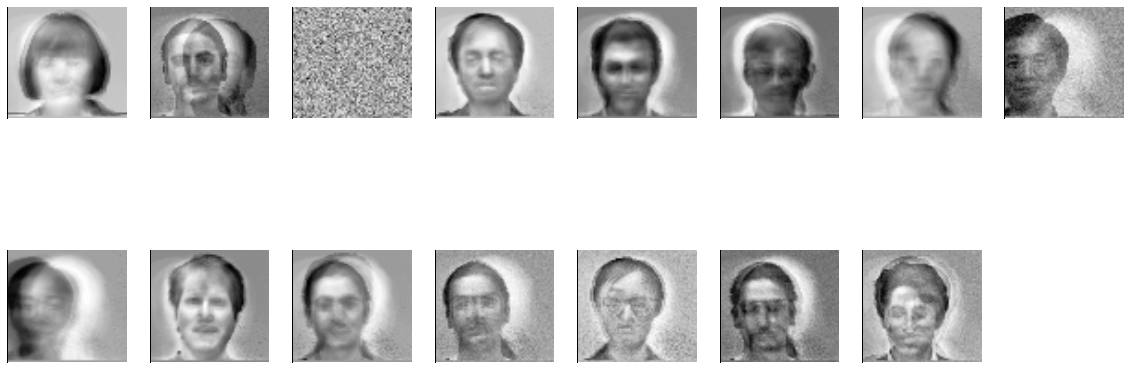

In [38]:
plt.figure(figsize=(20,8))

normalizingConstant = np.sqrt(np.sum(np.square(averageFace)))

for i in range(numOutputs):
    if numOutputs >= 8:
        plt.subplot(2,numOutputs//2+numOutputs%2,i+1)
    else:
        plt.subplot(1,numOutputs,i+1)
    util.facePlot(util.faceReshape(normalizingConstant*weights[:,i]+averageFace))